# Пайплайн

1. Считать все матрицы в `train` и `test` выборки
2. Обучить нейросеть

# Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

plt.rcParams.update({'font.size': 14})

In [161]:
import os

In [162]:
MSIZE = 256

In [163]:
MATRIX_DIR = "matrices"
MUSIC_DIR = "music"
PICS_DIR = "pics"
PDFS_DIR = "pdfs"

MUSIC_MATRIX_FULL_DIR = os.path.join(MATRIX_DIR, MUSIC_DIR)
PICS_MATRIX_FULL_DIR = os.path.join(MATRIX_DIR, PICS_DIR)
PDFS_MATRIX_FULL_DIR = os.path.join(MATRIX_DIR, PDFS_DIR)

MUSIC_MATRICIES = list(map(
    lambda x: os.path.join(MUSIC_MATRIX_FULL_DIR, x),
    os.listdir(MUSIC_MATRIX_FULL_DIR)
))
PICS_MATRICIES = list(map(
    lambda x: os.path.join(PICS_MATRIX_FULL_DIR, x),
    os.listdir(PICS_MATRIX_FULL_DIR)
))
PDFS_MATRICIES = list(map(
    lambda x: os.path.join(PDFS_MATRIX_FULL_DIR, x),
    os.listdir(PDFS_MATRIX_FULL_DIR)
))

print(MUSIC_MATRICIES[0])
print(PICS_MATRICIES[0])
print(PDFS_MATRICIES[0])

N_MUSIC = len(MUSIC_MATRICIES)
N_PICS  = len(PICS_MATRICIES)
N_PDFS  = len(PDFS_MATRICIES)


matrices/music/file_100.wav.bin
matrices/pics/file_240.jpg.bin
matrices/pdfs/file_223.pdf.bin


In [164]:
matricies = [
    np.zeros((N_MUSIC, MSIZE, MSIZE)),
    np.zeros((N_PICS, MSIZE, MSIZE)),
#     np.zeros((N_PDFS, MSIZE, MSIZE)),
]

for mat in matricies:
    print(mat.shape)

(870, 256, 256)
(761, 256, 256)


In [165]:
# %%timeit -r 5 -n 5 
for i, mat in tqdm(enumerate(MUSIC_MATRICIES)):
    matricies[0][i] = np.fromfile(mat, dtype=np.uint32).reshape((MSIZE, MSIZE))
    
for i, mat in tqdm(enumerate(PICS_MATRICIES)):
    matricies[1][i] = np.fromfile(mat, dtype=np.uint32).reshape((MSIZE, MSIZE))
    
# for i, mat in tqdm(enumerate(PDFS_MATRICIES)):
#     matricies[2][i] = np.fromfile(mat, dtype=np.uint32).reshape((MSIZE, MSIZE))

870it [00:01, 515.24it/s]
761it [00:01, 549.75it/s]


# Предваритальная обработка

In [78]:
S = 7.0
SIGMA = (S, S)

In [79]:
def smooth(mat):
    return gaussian_filter(mat, SIGMA, mode='constant', cval=mat.mean())

In [166]:
Ns = [
    N_MUSIC,
    N_PICS,
#     N_PDFS,
]

N_sample = min(Ns)

data_mats = np.zeros((len(Ns), N_sample, MSIZE, MSIZE))
data_mats.shape

(2, 761, 256, 256)

In [167]:
# %%timeit -n 5 -r 5
# matricies = np.array(list(map(smooth, matricies)))
for i in range(data_mats.shape[0]):
    for j in tqdm(range(data_mats.shape[1])):
        data_mats[i,j] = smooth(matricies[i][j])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 761/761 [00:02<00:00, 267.55it/s]


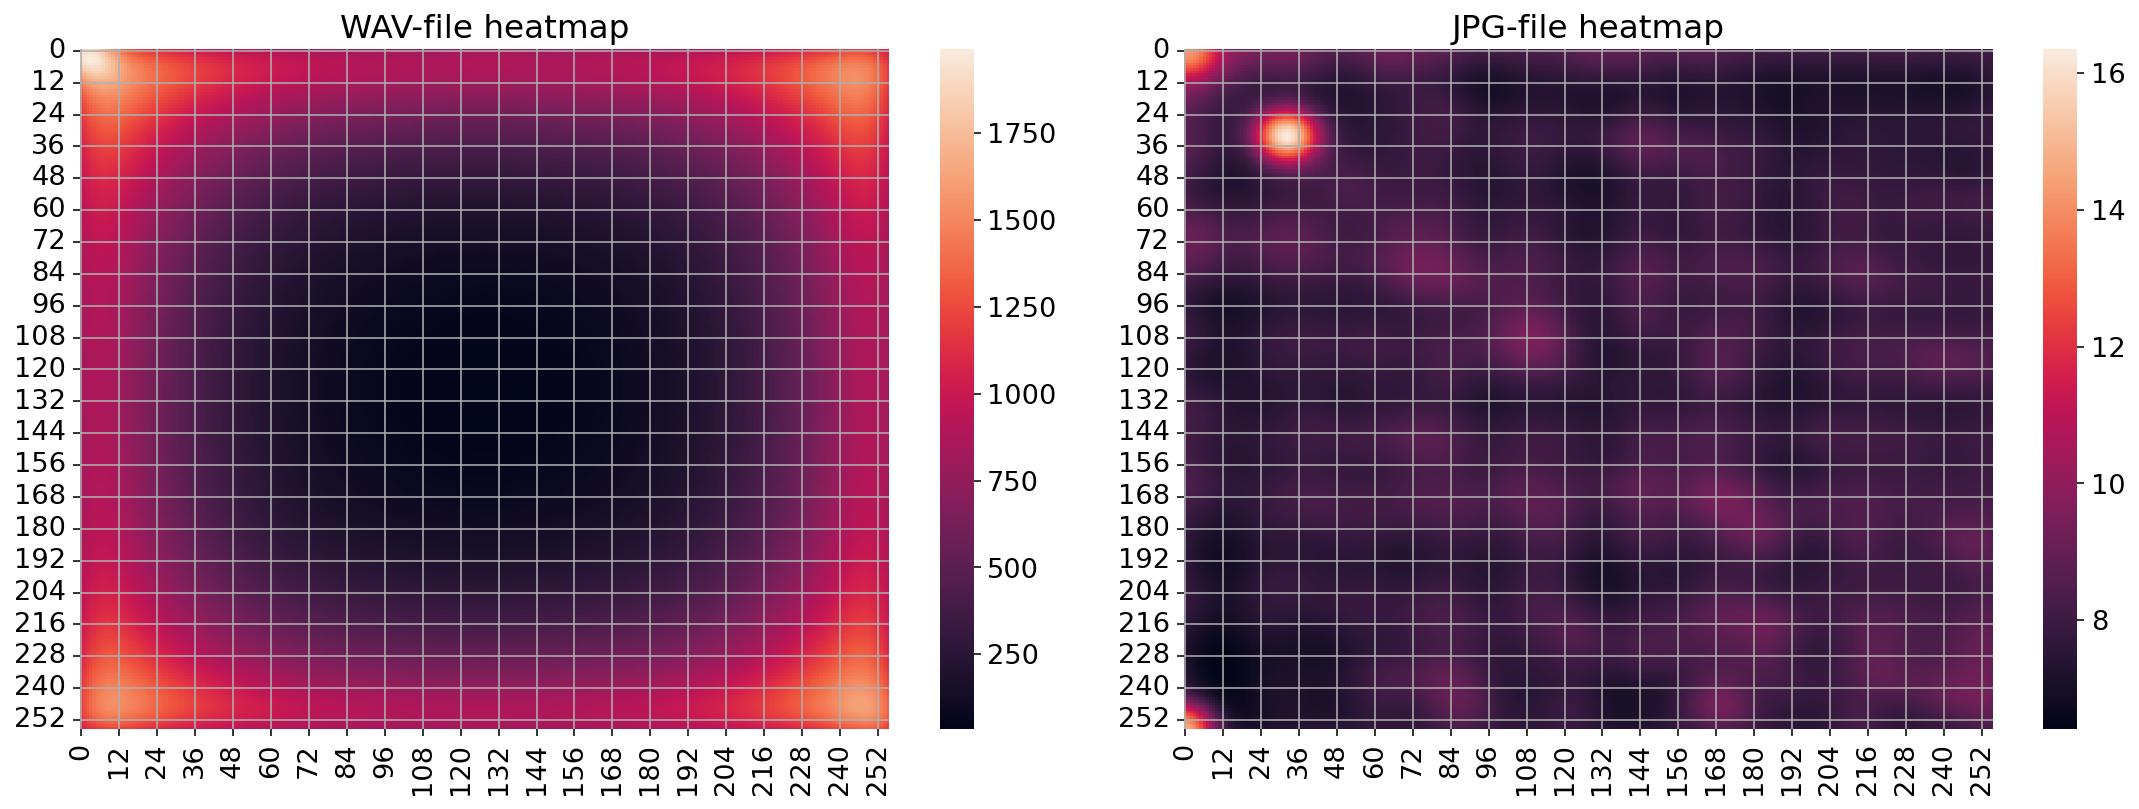

In [170]:
fig, ax = plt.subplots(1, len(Ns), figsize=(16,6), dpi=140)
# ax[0].grid()
# ax.set_xlim(1, 70)
# ax.set(xlabel='common xlabel', ylabel='common ylabel')

titles = [
    "WAV-file heatmap",
    "JPG-file heatmap",
    "PDF-file heatmap",
]

for i, n in enumerate(Ns):
    ax[i].grid()
    ax[i].set(
        title=titles[i],
    )
    sns.heatmap(data=data_mats[i].mean(axis=0), ax=ax[i])

plt.tight_layout()

# Обучение нейросети

In [171]:
import torch as t
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Подготовка выборок

In [172]:
data_mats.shape

(2, 761, 256, 256)

In [173]:
data = np.zeros((len(Ns) * N_sample, MSIZE, MSIZE))

for i in range(data_mats.shape[0]):
    for j in range(N_sample):
        data[i*N_sample + j] = data_mats[i,j].copy()

data = data.reshape((data.shape[0], MSIZE**2))
print(data.shape)

(1522, 65536)


In [174]:
labels = np.zeros((len(Ns)* data_mats.shape[1], 1), dtype=np.uint8)

for i in range(len(Ns)):
#     # WAV - 0
#     # JPG - 1
#     # PDF - 2
    labels[i*N_sample:(i+1)*N_sample] = i
labels.shape, data.shape

((1522, 1), (1522, 65536))

In [175]:
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=test_size, random_state=1234)

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

X_train = t.from_numpy(X_train.astype(np.float32))
X_test = t.from_numpy(X_test.astype(np.float32))
y_train = t.from_numpy(y_train.astype(np.float32))
y_test = t.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

## Формирование нейросети

In [176]:
device = t.accelerator.current_accelerator().type if t.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [196]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(MSIZE**2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Sigmoid(),
#             nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
#         x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return t.sigmoid(logits)

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=65536, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [197]:
loss_fn = nn.BCELoss()
optimizer = t.optim.SGD(model.parameters(), lr=1e-2)

In [198]:
num_epochs = 100
for epoch in range(num_epochs):
    # forward
    y_pred = model(X_train)
    # loss
    loss = loss_fn(y_pred, y_train)
    
    # backward
    loss.backward()
    
    # update
    optimizer.step()
    
    # zero gradient
    optimizer.zero_grad()
    
    if (epoch + 1) % (num_epochs // 15 + 1) == 0:
        print(f'epoch {epoch + 1:3d}: loss = {loss.item():.4f}')

epoch   7: loss = 0.6611
epoch  14: loss = 0.6355
epoch  21: loss = 0.5846
epoch  28: loss = 0.4678
epoch  35: loss = 0.3736
epoch  42: loss = 0.2812
epoch  49: loss = 0.2358
epoch  56: loss = 0.1918
epoch  63: loss = 0.1674
epoch  70: loss = 0.1473
epoch  77: loss = 0.1423
epoch  84: loss = 0.1194
epoch  91: loss = 0.1058
epoch  98: loss = 0.0989


In [200]:
with t.no_grad():
    y_pred = model(X_test)
    y_pred_cls = y_pred.round()
    
    acc = y_pred_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy = {acc:.4f}')

accuracy = 0.9934


In [201]:
(y_test - y_pred_cls).mean()

tensor(-0.0066)